In [1]:
# coding=utf-8
# Copyright 2024 The Language Tale Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Example for running the Language-Table environment."""

from collections.abc import Sequence
import random
from absl import app

from language_table.environments import blocks as blocks_module
from language_table.environments import language_table
from language_table.environments.rewards import block2block, point2block
import numpy as np
from scipy.spatial.transform import Rotation   

from matplotlib import pyplot as plt

import pickle

2025-01-29 14:31:38.275417: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 14:31:38.282954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738189898.291635 1614621 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738189898.294129 1614621 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 14:31:38.303014: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:

env = language_table.LanguageTable(
    block_mode=blocks_module.LanguageTableBlockVariants.NOVEL_8,
    reward_factory=point2block.PointToBlockReward,
    control_frequency=10.0,
)
ts= env.reset()
traj = pickle.load(open("/language_table/new_test_ds/demos/blocktoabsolutelocation_0_success.pkl", "rb"))
# env.set_pybullet_state(traj["initial_state"])

argv[0]=


/home/jacob/miniforge3/envs/table2/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [3]:
for _ in range(10):
    ts, _, _, _= env.step(env.action_space.sample())
block_positions = env.get_block_states()

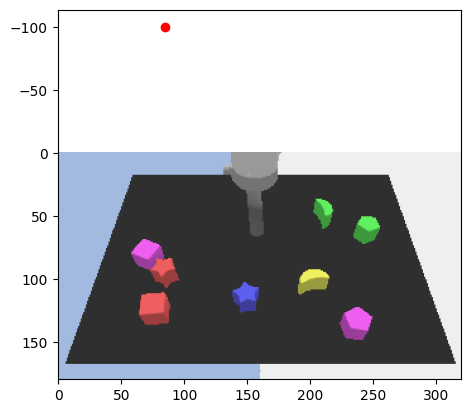

In [4]:
from language_table.environments.constants import CENTER_X, CENTER_Y
# def get_image_coords(pose, env):
#     viewm, projm, front_position, lookat, updir = env.calc_camera_params(env.image_size)
#     # convert the tuples to np arrays
#     view_matrix = np.array(viewm).reshape(4, 4).T
#     projection_matrix = np.array(projm).reshape(4, 4).T
#     clip_coords = projection_matrix @ (view_matrix @ pose)
#     w = clip_coords[3]

#     # if abs(w) > 1e-2:
#     #     ndc = clip_coords[:3] / w
#     #     print(f"w is not zero, {w}.")
#     # else:
#     #     ndc = clip_coords[:3] / w
#     ndc = clip_coords[:3] / w
#     ndc_x = ndc[0]
#     ndc_y = ndc[1]  

#     # Convert NDC coordinates to pixel coordinates
#     pixel_x = int(round((ndc_x + 1.0) * (screen_width - 1) * 0.5))
#     pixel_y = int(round((1.0 - ndc_y) * (screen_height - 1) * 0.5))
#     return pixel_x, pixel_y

rgb = ts['rgb']
peg_pose = block_positions['red_star']
pixel_x, pixel_y = env.get_camera_pix_coords(peg_pose)

plt.imshow(rgb)
plt.scatter(pixel_x, pixel_y, c='r')
plt.show()

[248.22608559 119.66389507   0.6264691 ]
[396.23037681 191.01324553   1.        ]


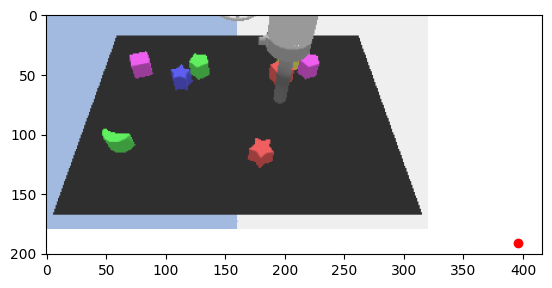

In [ ]:
rgb = ts["rgb"]

def get_camera_matrix(env):
    camera_pos, camera_orientation = env._camera_pose, env._camera_orientation
    # convert the euler angles to rotation matrix
    camera_orientation = Rotation.from_euler("xyz", camera_orientation).as_matrix()
    camera_transform_matrix = np.eye(4)
    camera_transform_matrix[:3, :3] = camera_orientation
    camera_transform_matrix[:3, 3] = np.array(camera_pos)
    return camera_transform_matrix

state = get_env_state(env)
extrinsic_matrix = get_camera_matrix(env)

peg_pose = state['purple_cube']
# peg_pose = np.array([0, .1])
peg_pose = np.append(peg_pose, [0, 1])

intrinsics = env._camera_instrinsics
intrinsics = np.array(intrinsics).reshape(3, 3)

peg_pose_camera_frame = np.dot(extrinsic_matrix, peg_pose)[:3]
peg_pixles = np.dot(intrinsics, peg_pose_camera_frame)

print(peg_pixles)
peg_pixles = peg_pixles / peg_pixles[2]
print(peg_pixles)
plt.imshow(rgb)
plt.scatter(peg_pixles[0], peg_pixles[1], c='r')
plt.show()





{'red_moon': array([ 0.23424236, -0.09522035]),
 'red_pentagon': array([0.39713196, 0.01191972]),
 'blue_moon': array([0.3564004 , 0.17620911]),
 'blue_cube': array([0.25406724, 0.19628257]),
 'yellow_star': array([0.42733331, 0.18481742]),
 'yellow_pentagon': array([ 0.23365758, -0.05621888]),
 'green_cube': array([0.28028246, 0.15690898]),
 'green_star': array([ 0.34808317, -0.19370312]),
 'peg': array([ 0.3705202, -0.3048   ], dtype=float32)}

In [11]:
import re

traj
for i, x in enumerate(traj['qa_pairs'][0]):
    x, _ = x
    if re.search("red moon block touching the red pentagon", x):
        print(i, x)

0 Is the red moon block touching the red pentagon block?


In [121]:
visible_block_ids = [env._block_to_pybullet_id[i] for i in env._blocks_on_table]
ids_to_names = {v: k for k, v in env._block_to_pybullet_id.items()}
blocks = [obj for obj in env.get_pybullet_state()["objects"] if obj.obj_id in visible_block_ids]

In [128]:
"""Questions I want to ask:
Is block x touching block y?
"""

n_blocks = len(blocks)
block_to_block_results = {}
for i in range(n_blocks):
    for j in range(i + 1, n_blocks):
        block_x, _ = blocks[i].base_pose
        block_y, _ = blocks[j].base_pose
        block_x_id = blocks[i].obj_id
        block_y_id = blocks[j].obj_id
        # Calculate Euclidean distance
        distance = np.linalg.norm(np.array(block_x)[:2] - np.array(block_y)[:2])
        is_touching = distance < 0.05  # Define touching threshold
        
        # Populate results dictionary
        block_to_block_results[f'Is the {ids_to_names[block_x_id].replace("_", " ")} block touching the {ids_to_names[block_y_id].replace("_", " ")} block?'] = is_touching
block_to_block_results

{'Is the red moon block touching the red pentagon block?': False,
 'Is the red moon block touching the blue moon block?': False,
 'Is the red moon block touching the blue cube block?': False,
 'Is the red moon block touching the yellow star block?': False,
 'Is the red moon block touching the yellow pentagon block?': True,
 'Is the red moon block touching the green cube block?': False,
 'Is the red moon block touching the green star block?': False,
 'Is the red pentagon block touching the blue moon block?': False,
 'Is the red pentagon block touching the blue cube block?': False,
 'Is the red pentagon block touching the yellow star block?': False,
 'Is the red pentagon block touching the yellow pentagon block?': False,
 'Is the red pentagon block touching the green cube block?': False,
 'Is the red pentagon block touching the green star block?': False,
 'Is the blue moon block touching the blue cube block?': False,
 'Is the blue moon block touching the yellow star block?': False,
 'Is 

In [92]:
from language_table.environments.rewards.block2block_relative_location import MAGNITUDE_X, MAGNITUDE_Y, MAGNITUDE_X_DIAG, MAGNITUDE_Y_DIAG, DIRECTIONS, BLOCK2BLOCK_REL_LOCATION_TARGET_DISTANCE
def reward_for(pushing_block, target_block, direction, scale=1.3):
    """Gets reward for a pushing block and a relative location."""
    pushing_block_translation, _ = pushing_block.base_pose
    target_block_translation, _ = target_block.base_pose
    # remove the z component
    pushing_block_translation = np.array(pushing_block_translation)[:2]
    target_block_translation = np.array(target_block_translation)[:2]
    
    
    # Consider the end point of the line 2x longer than the offset.
    mag_x = MAGNITUDE_X_DIAG if 'diagonal' in direction else MAGNITUDE_X
    mag_y = MAGNITUDE_Y_DIAG if 'diagonal' in direction else MAGNITUDE_Y
    target_vector = np.array(DIRECTIONS[direction]) * np.array(
        [mag_x*scale, mag_y*scale])
    # Define target_translation (where to push to) as target block translation
    # offset by target_vector.
    offset_translation = np.array(target_block_translation) + target_vector

    diff = offset_translation - target_block_translation
    # Consider all points half the distance from target block to offset.
    minpoint = diff * 0.5
    # Consider all points 10% further than the offset.
    maxpoint = diff * 1.1
    # Is the target block somewhere on the line between min point and max point?
    diffs = np.linspace(minpoint, maxpoint, 10)
    pushing_block_on_line = False
    for cand_offset in diffs:
      point = target_block_translation + cand_offset
      dist = np.linalg.norm(point - pushing_block_translation)
      if dist < BLOCK2BLOCK_REL_LOCATION_TARGET_DISTANCE:
        pushing_block_on_line = True
        break


    return pushing_block_on_line

In [105]:
print(ids_to_names)
visible_block_ids

{4: 'red_moon', 5: 'red_cube', 6: 'red_star', 7: 'red_pentagon', 8: 'blue_moon', 9: 'blue_cube', 10: 'blue_star', 11: 'blue_pentagon', 12: 'yellow_moon', 13: 'yellow_cube', 14: 'yellow_star', 15: 'yellow_pentagon', 16: 'green_moon', 17: 'green_cube', 18: 'green_star', 19: 'green_pentagon'}


[4, 7, 8, 9, 17, 18, 14, 15]

In [112]:
"""
Questions I want to ask: Is the red cresent to the left of the blue square?
"""

from language_table.environments.rewards.block2block_relative_location import DIRECTION_IDS, DIRECTION_SYNONYMS
relative_questions = {}
for i in range(10):
    # question_block, target_block = random.sample(blocks, k=2)
    question_block, target_block = blocks[6], blocks[2]
    target_direction = random.choice(DIRECTION_IDS)
    target_string = random.choice(DIRECTION_SYNONYMS[target_direction])
    
    is_satisfied = reward_for(question_block, target_block, target_direction)
    question = f"Is the {ids_to_names[question_block.obj_id].replace('_', ' ')} block {target_string} the {ids_to_names[target_block.obj_id].replace('_', ' ')} block?"
    relative_questions[question] = is_satisfied
relative_questions

{'Is the green cube block just right of the the blue moon block?': False,
 'Is the green cube block to the bottom of the the blue moon block?': True,
 'Is the green cube block to the bottom right side of the the blue moon block?': True,
 'Is the green cube block to the top of the the blue moon block?': False,
 'Is the green cube block diagonally down and to the right of the the blue moon block?': True,
 'Is the green cube block diagonally down and to the left of the the blue moon block?': False,
 'Is the green cube block to the top right side of the the blue moon block?': False,
 'Is the green cube block to the left side of the the blue moon block?': False}

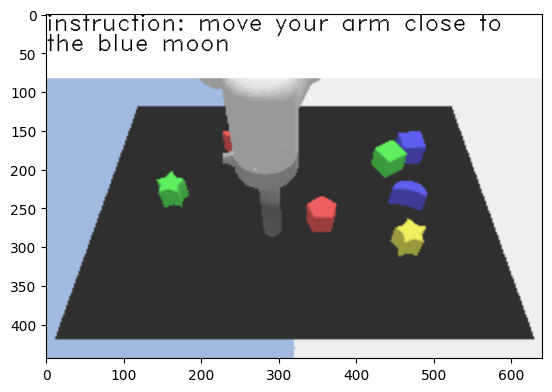

In [124]:
plt.imshow(env.render())

In [54]:
"""
Question that I want to ask: Is the peg next to the red cresent?
"""
from language_table.environments.rewards.constants import TARGET_BLOCK_DISTANCE


next_to_questions = {}
for block in blocks:
    block_position, _ = block.base_pose
    block_position = np.array(block_position)[:2]
    
    state = env._compute_state()

    dist = np.linalg.norm(
        np.array(block_position) -
        np.array(state['effector_target_translation']))
    question = f"Is the {ids_to_names[block.obj_id].replace('_', ' ')} block next to the peg"
    if dist < TARGET_BLOCK_DISTANCE:
        next_to_questions[question] = True
    else:
        next_to_questions[question] = False
next_to_questions

{'Is the red moon block next to the peg': False,
 'Is the red pentagon block next to the peg': False,
 'Is the blue moon block next to the peg': False,
 'Is the blue cube block next to the peg': False,
 'Is the yellow star block next to the peg': False,
 'Is the yellow pentagon block next to the peg': False,
 'Is the green cube block next to the peg': False,
 'Is the green star block next to the peg': False}

In [116]:
"""
Question: Is the red cresent in the center of the board?
"""
from language_table.environments.rewards.block2absolutelocation import LOCATION_SYNONYMS, ABSOLUTE_LOCATIONS, Locations, BLOCK2ABSOLUTELOCATION_CENTER_TARGET_DISTANCE, BLOCK2ABSOLUTELOCATION_TARGET_DISTANCE
position_questions = {}
for i in range(10):
    block = random.choice(blocks)
    target_translation = random.choice(list(ABSOLUTE_LOCATIONS.keys()))


    # Get current location of the target block.
    current_translation, _ = block.base_pose
    current_translation = np.array(current_translation)[:2]
    # Compute distance between current translation and target.
    dist = np.linalg.norm(
        np.array(current_translation) - np.array(ABSOLUTE_LOCATIONS[target_translation]))

    if target_translation ==  Locations.CENTER.value:
      target_dist = BLOCK2ABSOLUTELOCATION_CENTER_TARGET_DISTANCE
    else:
      target_dist = BLOCK2ABSOLUTELOCATION_TARGET_DISTANCE

    success =  dist < target_dist

    question = f"Is the {ids_to_names[block.obj_id].replace('_', ' ')} block in the {random.choice(LOCATION_SYNONYMS[target_translation])} of the board?"
    position_questions[question] = success
position_questions

{'Is the green cube block in the lower right corner of the board?': False,
 'Is the blue moon block in the left side of the board of the board?': False,
 'Is the blue cube block in the upper right corner of the board?': False,
 'Is the yellow pentagon block in the top of the board?': False,
 'Is the yellow star block in the lower right corner of the board?': False,
 'Is the green star block in the right side of the board of the board?': False,
 'Is the red moon block in the bottom left of the board?': False,
 'Is the red moon block in the top right corner of the board?': False,
 'Is the red moon block in the top side of the board?': False,
 'Is the green cube block in the center of the board?': True}

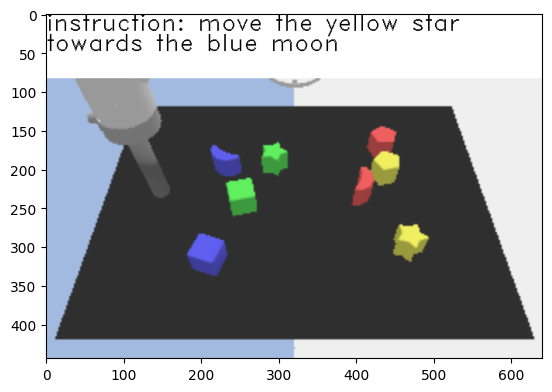

In [117]:
plt.imshow(env.render())